# Modules and settings

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

sns.set()
plt.rcParams["figure.figsize"] = (20,10)

# Import, clean, merge, split data

In [175]:
# Import data
data_generation1 = pd.read_csv('Plant_1_Generation_Data.csv')
data_weather1 = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')

# Format dates
data_generation1['DATE_TIME'] = pd.to_datetime(data_generation1['DATE_TIME'], format='%d-%m-%Y %H:%M', dayfirst=True)
data_weather1['DATE_TIME'] = pd.to_datetime(data_weather1['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Drop and group
data_generation1.drop(['PLANT_ID'], axis=1, inplace=True)
data_generation1 = data_generation1.groupby(['DATE_TIME']).sum().reset_index()
data_generation1.drop(['SOURCE_KEY'], axis=1, inplace=True)
data_weather1.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1, inplace=True)

# Add hours and minutes, and relative time
data_generation1['HOUR_MINUTE'] = data_generation1['DATE_TIME'].dt.strftime('%H:%M')
data_generation1['HOUR'] = data_generation1['DATE_TIME'].dt.hour
data_generation1['MINUTE'] = data_generation1['DATE_TIME'].dt.minute
data_generation1['MINUTES_FROM_MIDDAY'] = abs((data_generation1['HOUR'] - 12) * 60 + data_generation1['MINUTE'])
# data_generation1['MINUTES_SINCE_MIDNIGHT'] = data_generation1['HOUR'] * 60 + data_generation1['MINUTE']
data_generation1.drop(['HOUR', 'MINUTE'], axis=1, inplace=True)

# Merge data
data_plant1 = pd.merge(data_generation1, data_weather1, how='outer', on=['DATE_TIME'], suffixes=('_generation', '_weather'))
# data_plant1 = data_plant1[['DATE_TIME', 'HOUR_MINUTE', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
# data_plant1.reset_index(drop=True, inplace=True)

# Deal with nulls
# print('Deal with nulls')
# print(data_plant1.isnull().sum())
# print(data_plant1[data_plant1.isnull().any(axis=1)])
data_plant1 = data_plant1.dropna(axis=0)

print('Processed data')
print(data_plant1.head(1))
print()
print(data_plant1.tail(1))
print()
print(data_plant1.describe(include='all'))
print()

# Split data into two halves
print('Split data')
unique_dates = data_plant1['DATE_TIME'].dt.date.unique()
unique_dates_n = len(unique_dates)
print(f'Unique dates: {unique_dates_n}')
# unique_dates.sort()
days_for_split = math.ceil(unique_dates_n/2)
dates_first_half = unique_dates[:days_for_split]
dates_second_half = unique_dates[days_for_split:]
data_plant1_first_half = data_plant1[data_plant1['DATE_TIME'].dt.date.isin(dates_first_half)].copy()
print(f"First half: {data_plant1_first_half.iloc[0]['DATE_TIME']} to {data_plant1_first_half.iloc[-1]['DATE_TIME']}")
data_plant1_second_half = data_plant1[data_plant1['DATE_TIME'].dt.date.isin(dates_second_half)].copy()
print(f"Second half: {data_plant1_second_half.iloc[0]['DATE_TIME']} to {data_plant1_second_half.iloc[-1]['DATE_TIME']}")

# Old stuff
# data_weather1 = data_weather1.groupby(['DATE_TIME']).mean().reset_index()
# data_generation1.set_index('DATE_TIME', inplace=True)
# data_weather1.set_index('DATE_TIME', inplace=True)
# print(data_generation1.head(1).to_string(index=False, line_width=1000))

Processed data
   DATE_TIME  DC_POWER  AC_POWER  DAILY_YIELD  TOTAL_YIELD HOUR_MINUTE  \
0 2020-05-15       0.0       0.0          0.0  143581676.0       00:00   

   MINUTES_FROM_MIDDAY  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  
0                720.0            25.184316           22.857507          0.0  

               DATE_TIME  DC_POWER  AC_POWER    DAILY_YIELD  TOTAL_YIELD  \
3182 2020-06-17 23:45:00       0.0       0.0  127962.767857  156142755.0   

     HOUR_MINUTE  MINUTES_FROM_MIDDAY  AMBIENT_TEMPERATURE  \
3182       23:45                705.0            21.909288   

      MODULE_TEMPERATURE  IRRADIATION  
3182           20.427972          0.0  

                            DATE_TIME       DC_POWER      AC_POWER  \
count                            3157    3157.000000   3157.000000   
unique                            NaN            NaN           NaN   
top                               NaN            NaN           NaN   
freq                              NaN 

# Plot

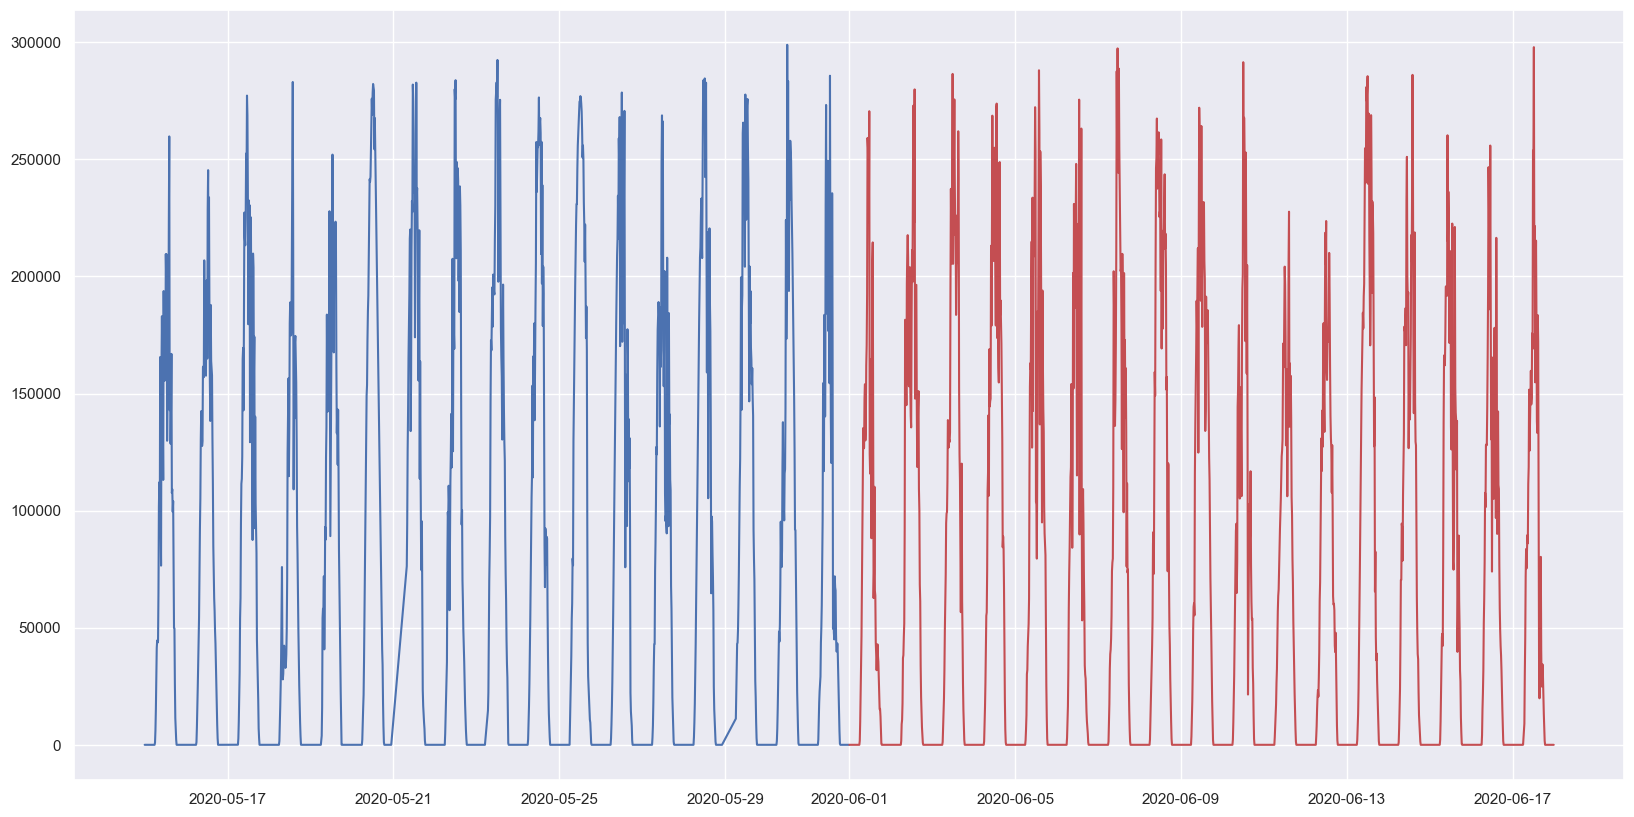

In [195]:
x = data_plant1_first_half['DATE_TIME']
y = data_plant1_first_half['DC_POWER']
plt.plot(x,y,c='b')
x = data_plant1_second_half['DATE_TIME']
y = data_plant1_second_half['DC_POWER']
plt.plot(x,y,c='r')
plt.show()

# Daily sums and averages

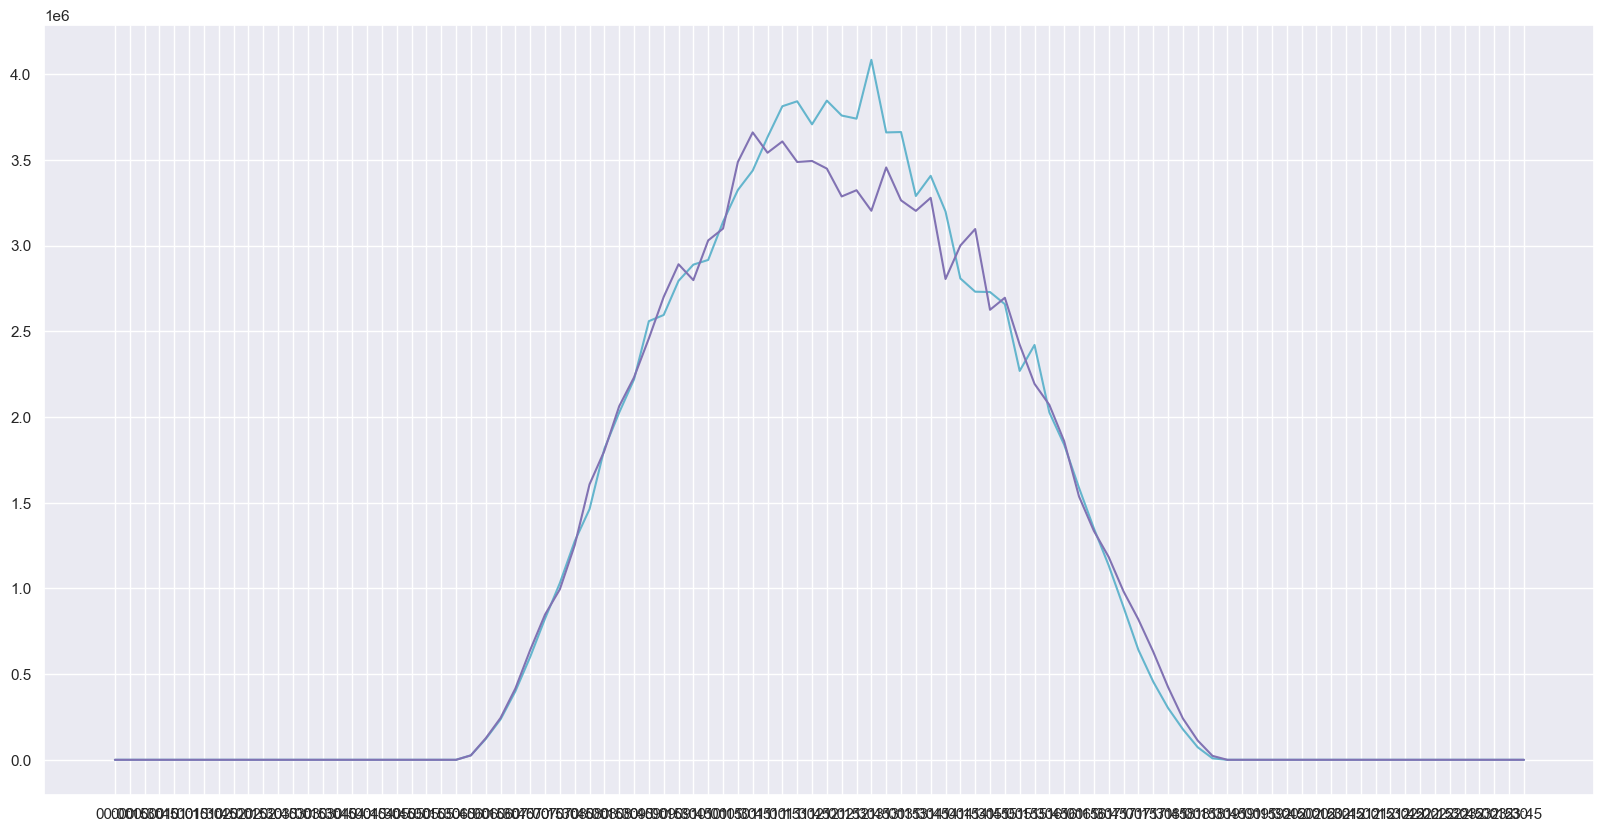

In [133]:
scaler = MinMaxScaler()

# Averages, scaled
# data_plant1_first_half_avg = data_plant1_first_half[['HOUR_MINUTE','DC_POWER']].groupby('HOUR_MINUTE').mean().reset_index()
# data_plant1_second_half_avg = data_plant1_second_half[['HOUR_MINUTE','DC_POWER']].groupby('HOUR_MINUTE').mean().reset_index()

# x = data_plant1_first_half_avg['HOUR_MINUTE']
# y = pd.DataFrame(scaler.fit_transform(data_plant1_first_half_avg[['DC_POWER']]))
# # y = data_plant1_first_half_avg['DC_POWER']
# plt.plot(x,y,c='b')

# x = data_plant1_second_half_avg['HOUR_MINUTE']
# # y = data_plant1_second_half_avg['DC_POWER']
# y = pd.DataFrame(scaler.fit_transform(data_plant1_second_half_avg[['DC_POWER']]))
# plt.plot(x,y,c='r')

# Sums (scaled commented out)
data_plant1_first_half_sum = data_plant1_first_half[['HOUR_MINUTE','DC_POWER']].groupby('HOUR_MINUTE').sum().reset_index()
data_plant1_second_half_sum = data_plant1_second_half[['HOUR_MINUTE','DC_POWER']].groupby('HOUR_MINUTE').sum().reset_index()

x = data_plant1_first_half_sum['HOUR_MINUTE']
y = data_plant1_first_half_sum['DC_POWER']
# y = pd.DataFrame(scaler.fit_transform(data_plant1_first_half_sum[['DC_POWER']]))
plt.plot(x,y,c='c')

x = data_plant1_second_half_sum['HOUR_MINUTE']
y = data_plant1_second_half_sum['DC_POWER']
# y = pd.DataFrame(scaler.fit_transform(data_plant1_second_half_sum[['DC_POWER']]))
plt.plot(x,y,c='m')

# Show plot
plt.show()

# Scatter and Histogram

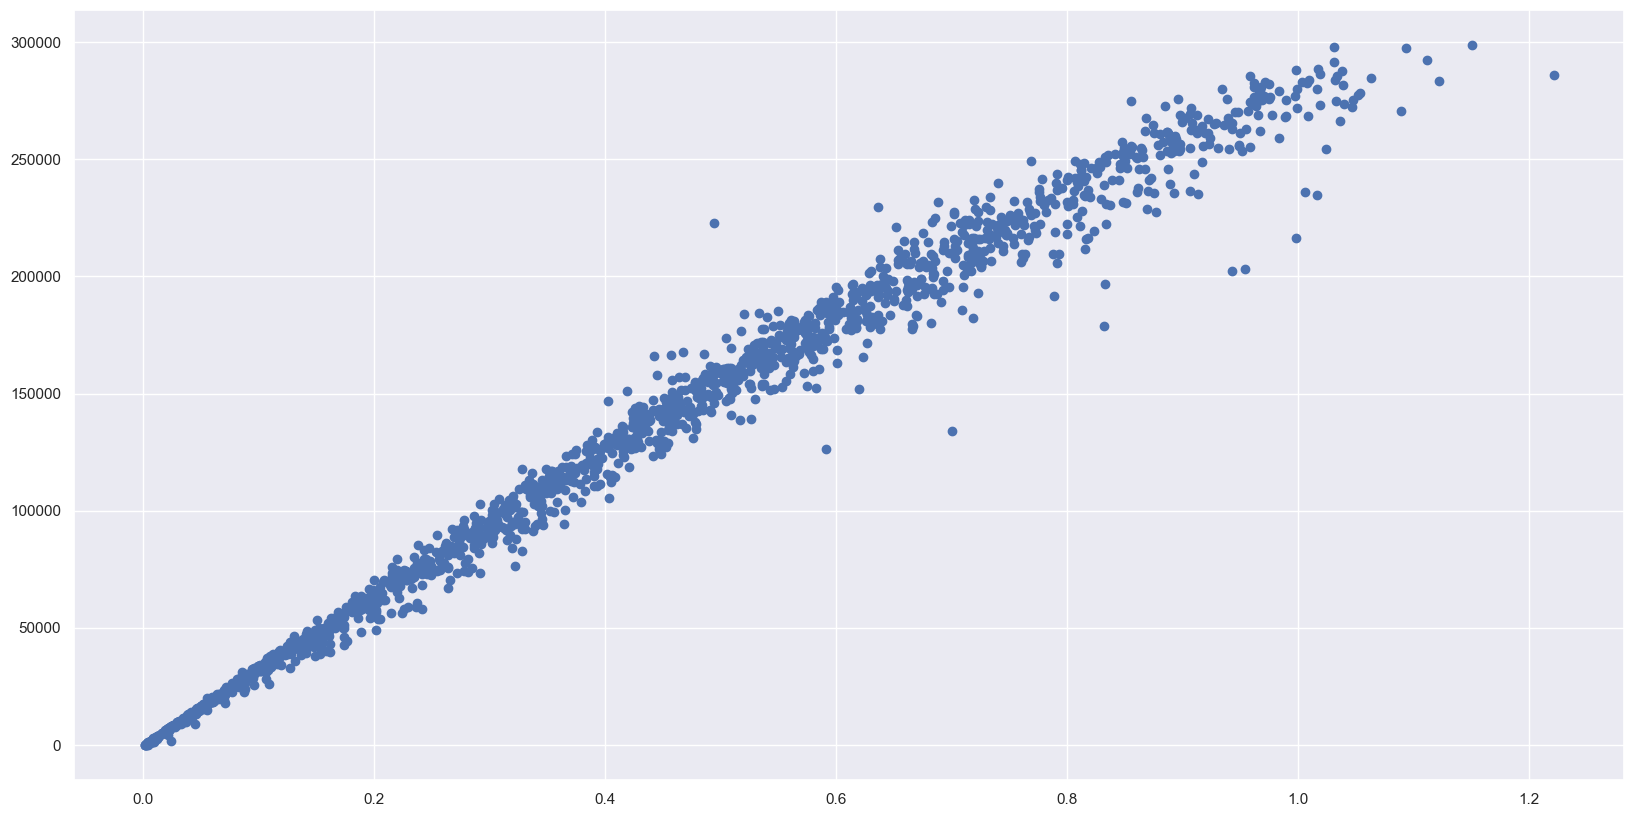

In [188]:
data_plant1_active = data_plant1[data_plant1['IRRADIATION']>0]
data_plant1_active = data_plant1[data_plant1['DC_POWER']>0]
x = data_plant1_active['IRRADIATION']
# x = data_plant1_active['MINUTES_FROM_MIDDAY']
y = data_plant1_active['DC_POWER']
plt.scatter(x,y)
plt.show()

In [ ]:
sns.histplot(data_plant1_active['DC_POWER'])

# VIF and Linear Regression

         VIF             features
0  10.074464  MINUTES_FROM_MIDDAY
1  17.924584  AMBIENT_TEMPERATURE
2   6.341700          IRRADIATION


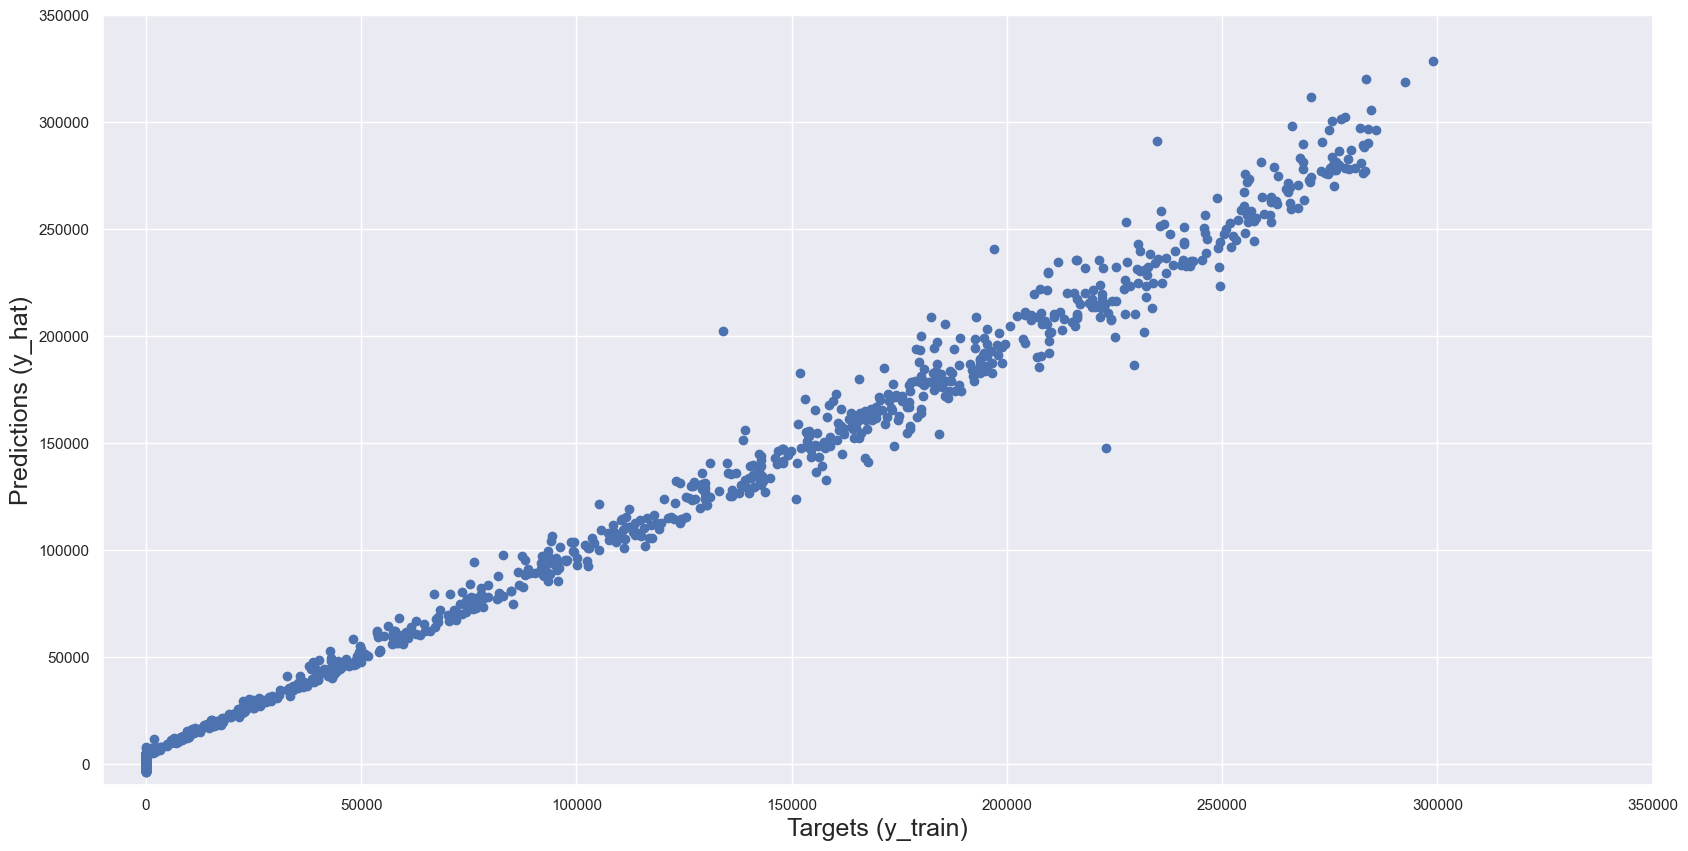

              Features       Weights
0  MINUTES_FROM_MIDDAY  -4000.159248
1  AMBIENT_TEMPERATURE    901.637830
2          IRRADIATION  82924.101116


In [197]:
# variables = data_plant1[['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD',
       # 'MINUTES_FROM_MIDDAY', 'AMBIENT_TEMPERATURE',
       # 'MODULE_TEMPERATURE', 'IRRADIATION']]
variables = data_plant1[['MINUTES_FROM_MIDDAY', 'AMBIENT_TEMPERATURE', 'IRRADIATION']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
print(vif)

data_plant1_no_multicollinearity = data_plant1[['DC_POWER', 'MINUTES_FROM_MIDDAY', 'AMBIENT_TEMPERATURE', 'IRRADIATION']]

targets = data_plant1_no_multicollinearity['DC_POWER']
inputs = data_plant1_no_multicollinearity.drop(['DC_POWER'],axis=1)

scaler = StandardScaler()
scaler.fit(inputs)
inputs_scaled = scaler.transform(inputs)
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.5, random_state=1, shuffle=False)
reg = LinearRegression()
reg.fit(x_train,y_train)
y_hat = reg.predict(x_train)
plt.scatter(y_train, y_hat)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
plt.xlim(-10000,350000)
plt.ylim(-10000,350000)
plt.show()

reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
print(reg_summary)

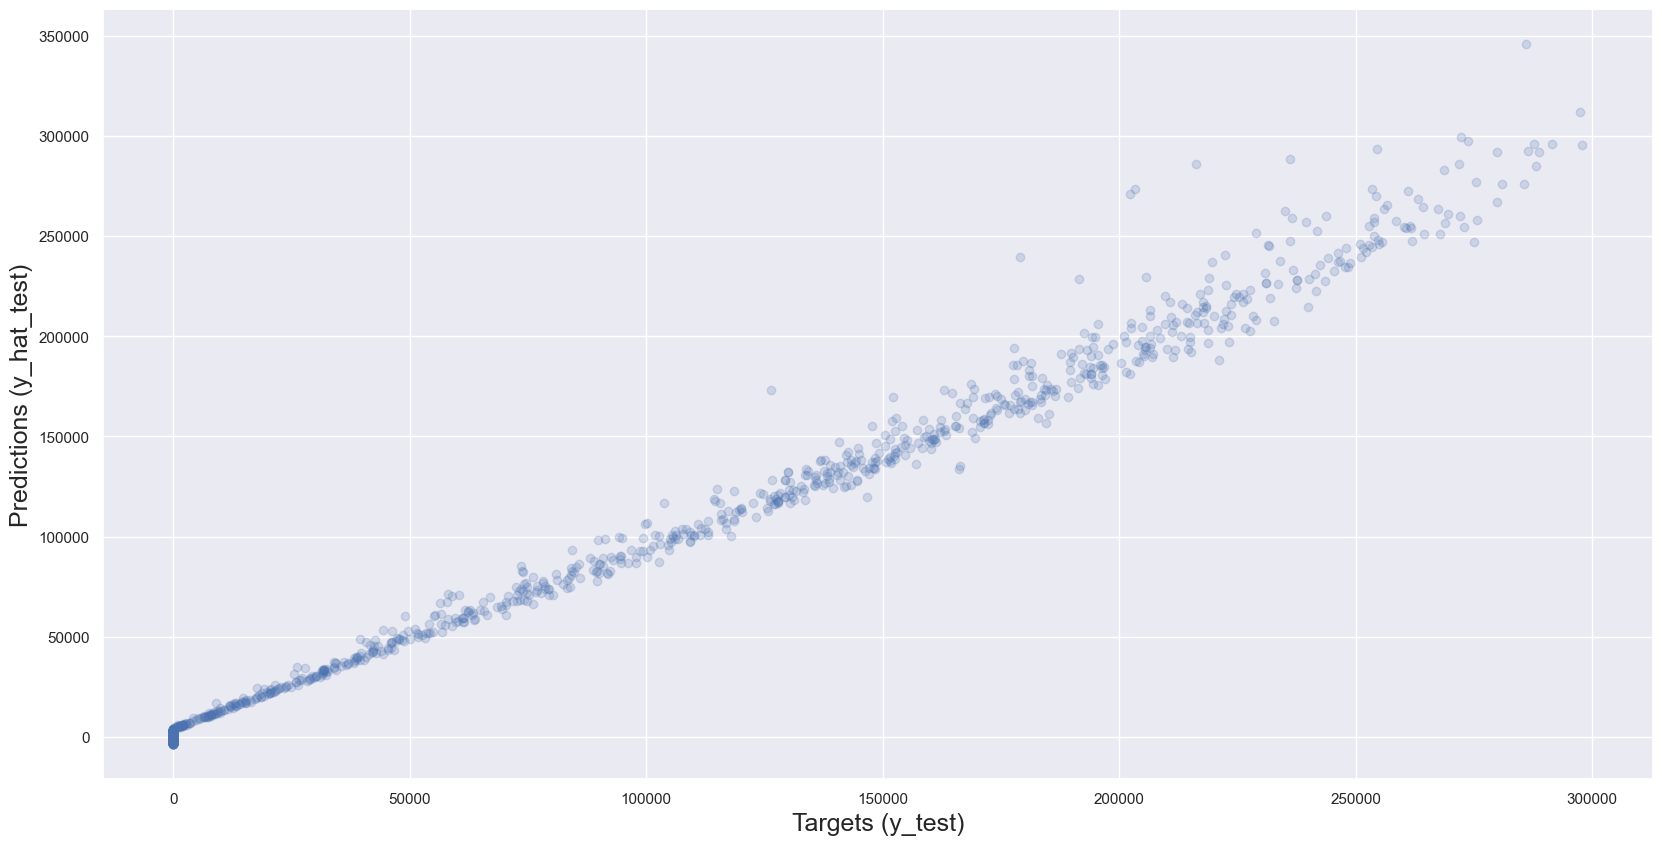

In [185]:
y_hat_test = reg.predict(x_test)
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.show()